#MobiAct_ADL_get_X_y_sub.ipynb. 
Loads the 6 Activities of Daily living (ADL) from the first release of the MobiAct dataset and converts to numpy arrays.  The total acceleration minus the gravity component is calculated.  Mostly interactive code with ability to create multiple directories based on a list. In each directory three numpy arrays and a info.txt file with parameters and timestamp will be stored.

Contents of the arrays will be:
X = accel data (samples, time steps per sample, accel_x/y/z/total_accel)
y = activity classification 
s = subject number

Developed and tested with the First release of MobiAct dataset

>Vavoulas, G., Chatzaki, C., Malliotakis, T., Pediaditis, M. and Tsiknakis, M., The MobiAct Dataset: Recognition of Activities of Daily Living using Smartphones.,In Proceedings of the International Conference on Information and Communication Technologies for Ageing Well and e-Health (ICT4AWE 2016), pages 143-151,ISBN: 978-989-758-180-9.

Example info.txt
>MobiAct Data resampled with 3s window size  
Saved to /content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_100Hz_3s_test  
Generated by MobiAct_ADL_get_X_y_sub.ipynb on Feb-26-2021_1607  
delta time step = 10ms time steps = 300, start_discard = 100, end_discard = 100  
X shape is (13792, 300, 4) data type is float64  
y shape is (13792, 1) data type is &gt;U3  
sub shape is (13792, 1) data type is int64  

Activities included
* STD Standing (1x5min)
* WAL Walking (1x5min)
* JOG Jogging (3x30sec)
* JUM Jumping (3x30sec)
* STU Stairs Up (6x10sec)
* STN Stairs Down (6x10sec)

Only the timestamp 'nanoseconds' and accelerometer data (accel_x/y/z) is imported from the dataset. Sitting, Fall, gyro, and orientation data is not used.   Metadata including the activity and subject are derived from the directory and filename  



Some functions are defined, but this is mostly meant to be run in interactive
mode with the files saved at the end.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Lee B. Hinkle, Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  

TODOs:
* Figure out how to download source directly from https://drive.google.com/file/d/0B5VcW5yHhWhibWxGRTZDd0dGY2s/edit. 
* Trim of segments could be improved along with a overlapping sliding window.
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
* Add a way to automatically generate no_resample version.

In [ ]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import requests #for downloading zip file
import glob # to generate lists of files in directory - unix style pathnames
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from keras.utils import to_categorical # for one-hot encoding

#vprint method for development and debugging

In [ ]:
verbose = False #@param {type:"boolean"}


In [ ]:
#create function to toggle print level.  Note: python logging may be better
#credit https://stackoverflow.com/users/416467/kindall
#https://stackoverflow.com/questions/5980042/how-to-implement-the-verbose-or-v-option-into-a-script
if verbose:
    print("Verbose mode on")
    def vprint(*args):
        # Print each argument separately so caller doesn't need to
        # stuff everything to be printed into a single string
        for arg in args:
           print (arg, end=" ")
        print()
else: 
    print("Verbose mode off")  
    vprint = lambda *a: None      # do-nothing function

Verbose mode off


#Unzip Mobiact datafile, build filename dataframe
The dataset file is available [here](https://https://drive.google.com/file/d/0B5VcW5yHhWhibWxGRTZDd0dGY2s)  
Easiest way to find path to mounted drive file in colab is:  
* mount your google drive with the MobiAct zip file
* navigate to the file using File menu to left
* right click on file and select 'copy path', paste in next line
* unzip original dataset from google drive map into colab session

In [ ]:
def unzip_mobiact(
    orig_zipfile = '/content/drive/My Drive/Datasets/MobiAct_Dataset_v1.0.zip',
    working_dir = '/content/MobiAct_Dataset' # location of unzipped files
    ):
    """check for local copy, if none unzips the mobiact structure in working_dir"""
    if (os.path.isdir(working_dir)):
        print("Using existing archive in colab")
        return
    else:
        print("Unzipping MobiAct dataset")
        if (os.path.exists(orig_zipfile)):
            print("Using source file", orig_zipfile)
            shutil.unpack_archive(orig_zipfile,'/content','zip')
        else:
            print("Error: ", orig_zipfile, " not found, exiting")
            return

In [ ]:
def get_mobiact_fnames(working_dir = '/content/MobiAct_Dataset'):
    """returns a dataframe with metadata based on mobiact directory structure

    args: path_in is location of files e.g. JOG, JUM, etc directories
    returns: pandas dataframe with one row for each file.
             columns are full filename, activity, subject"""
    df_flist = pd.DataFrame() # new empty dataframe
    ACT = ['JOG','JUM','STD','STN','STU','WAL']
    for i in ACT:    
        sub_path = working_dir +'/' + i + '/'
        fname_in = i + '_acc_*.txt'
        vprint("Generating filenames ", fname_in," from ", sub_path," directory")
        # Generates a list of all matching files in dir, create dataframe
        in_files = glob.glob(os.path.join(sub_path, fname_in)) 
        temp = pd.DataFrame(in_files,dtype="string")
        temp.columns = ['fname'] # name the column
        temp['ACT'] = i # i is the activity
        # Use pd method and regex get SUB from fname
        temp['SUB'] = temp['fname'].str.extract(r'(\d+)') 
        # both columns are type object, would be better to set but didn't work first time
        df_flist = pd.concat([df_flist,temp], ignore_index=True ) # concat needs two df, add regardless of index   
    vprint("Columns in df_list", df_flist.columns)
    vprint("Number of files per activity")
    vprint(df_flist.value_counts(subset=['ACT']))
    vprint("Number of files per subject")
    vprint(df_flist.value_counts(subset=['SUB'])) #are 20 files
    #TODO - make this shorter by printing only != 20 subjects
    vprint("First 5 lines of df_flist")
    vprint(df_flist.head(5))
    return df_flist

In [ ]:
unzip_mobiact()
df_flist = get_mobiact_fnames()
print(df_flist.shape) #(996, 3)

Unzipping MobiAct dataset
Using source file /content/drive/My Drive/Datasets/MobiAct_Dataset_v1.0.zip
(996, 3)


#Functions to manipulate the data

In [ ]:
def get_raw_mobiact_data(full_filename):
    """returns dataframe with data extracted from a Mobiact txt file
    
    args: full_filename e.g. /content/MobiAct_Dataset/JOG/JOG_acc_10_2.txt
    returns: dataframe with time and component accel x/y/z data"""
    df = pd.read_csv(full_filename,skiprows=16, header=None) #skip 16 lines of metadata
    df.columns = ["nanoseconds", "accel_x", "accel_y", "accel_z"]
    return df

In [ ]:
def add_total_accel(df_in):
    """computes rms of accel_x/y/z with 1g component removed in new column
    
    args: df with extracted Mobiact data
              rows = timesteps in original file
              columns must include "accel_x", "accel_y", "accel_z
          delete_xyz if True removes component acceleration
    returns:  df with total_accel column"""
    dfx = df_in.pow(2)[['accel_x','accel_y','accel_z']] #square each accel
    df_sum = dfx.sum(axis=1) #add sum of squares, new 1 col df
    df_out = df_in.copy() #otherwise modifies the original dataframe
    df_out.loc[:,'accel_total'] = df_sum.pow(0.5)-9.8  # sqrt and remove 1g
    del dfx, df_sum 
    return df_out

In [ ]:
def convert_index_to_datetime(df_in):
    """changes index from sample (line in csv) to nanoseconds in timedelta"""
    #time_delta_index = pd.TimedeltaIndex(df_in['nanoseconds'],unit='ns')
    #Orig 1/7/21 dt_index = pd.DatetimeIndex(df_in['nanoseconds'],unit='ns')
    dt_index = pd.DatetimeIndex(df_in['nanoseconds'])
    df_out = df_in.set_index(dt_index)
    df_out = df_out.drop(columns=['nanoseconds'])
    return df_out

In [ ]:
def to_fixed_timedelta(df_in, new_time_step='50ms'):
    """resamples DateTime indexed dataframe to new_time_step.  Will
    return NaN per resample method (happens on irregular samples)"""
    vprint("Resampling",new_time_step,": Original #rows = ",len(df_in.index))
    df_out = df_in.resample(new_time_step).mean()
    df_out = df_out.interpolate() #linear interpolation for nan
    vprint("Resampled: New #rows = ",len(df_out.index))
    return df_out

In [ ]:
#exploratory/debug code with separate df names
df_raw = get_raw_mobiact_data('/content/MobiAct_Dataset/JOG/JOG_acc_16_1.txt')
df_ttl = add_total_accel(df_raw)
df_time_indexed = convert_index_to_datetime(df_ttl)
print("---after get_raw_mobiact_data---\n",df_raw.head(5))
print("---after add_total_accel---\n",df_ttl.head(5))
print("---after convert_index_to_timedelta---\n",df_time_indexed.head(5))
df_resampled = to_fixed_timedelta(df_time_indexed, new_time_step='100ms')
print("---after resampling/interpolation---\n",df_time_indexed.head(5))
df_final = df_resampled.reset_index(drop=True) #index = row # not time data
print("---after reset_index---\n",df_final.head(5))

---after get_raw_mobiact_data---
       nanoseconds   accel_x    accel_y   accel_z
0  42423079427000  1.953669   9.538500  1.139640
1  42423280762000  0.440533   8.312668  0.881066
2  42423480994000 -1.350330  10.639832 -0.746991
3  42423491577000 -2.949656  11.262324 -0.679953
4  42423501299000 -3.945644  11.923124 -0.660800
---after add_total_accel---
       nanoseconds   accel_x    accel_y   accel_z  accel_total
0  42423079427000  1.953669   9.538500  1.139640     0.002988
1  42423280762000  0.440533   8.312668  0.881066    -1.429170
2  42423480994000 -1.350330  10.639832 -0.746991     0.951159
3  42423491577000 -2.949656  11.262324 -0.679953     1.862022
4  42423501299000 -3.945644  11.923124 -0.660800     2.776393
---after convert_index_to_timedelta---
                              accel_x    accel_y   accel_z  accel_total
nanoseconds                                                           
1970-01-01 11:47:03.079427  1.953669   9.538500  1.139640     0.002988
1970-01-01 11:47:0

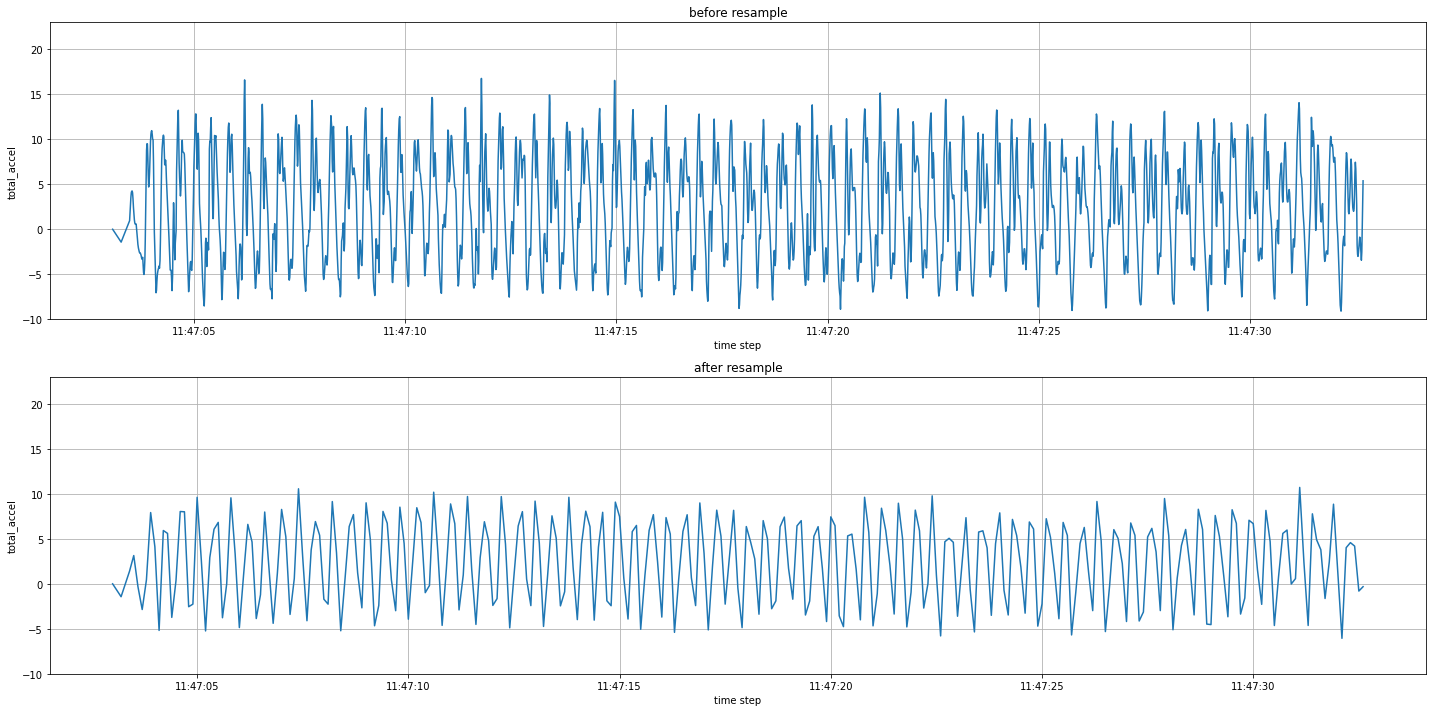

In [ ]:
#exploratory code - plot before and after resample
fig, axs = plt.subplots(2, 1,figsize=(20,10))
axs[0].set_ylim(-10, 23) #min and max in entire dataset
axs[0].plot(df_time_indexed['accel_total'])
axs[0].set_title('before resample')
axs[0].set_xlabel("time step")
axs[0].set_ylabel("total_accel")
axs[0].grid(True)
axs[1].set_ylim(-10, 23) #min and max in entire dataset
axs[1].plot(df_resampled['accel_total'])
axs[1].set_title('after resample')
axs[1].set_xlabel("time step")
axs[1].set_ylabel("total_accel")
axs[1].grid(True)

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  # Remove the CWD from sys.path while we load stuff.


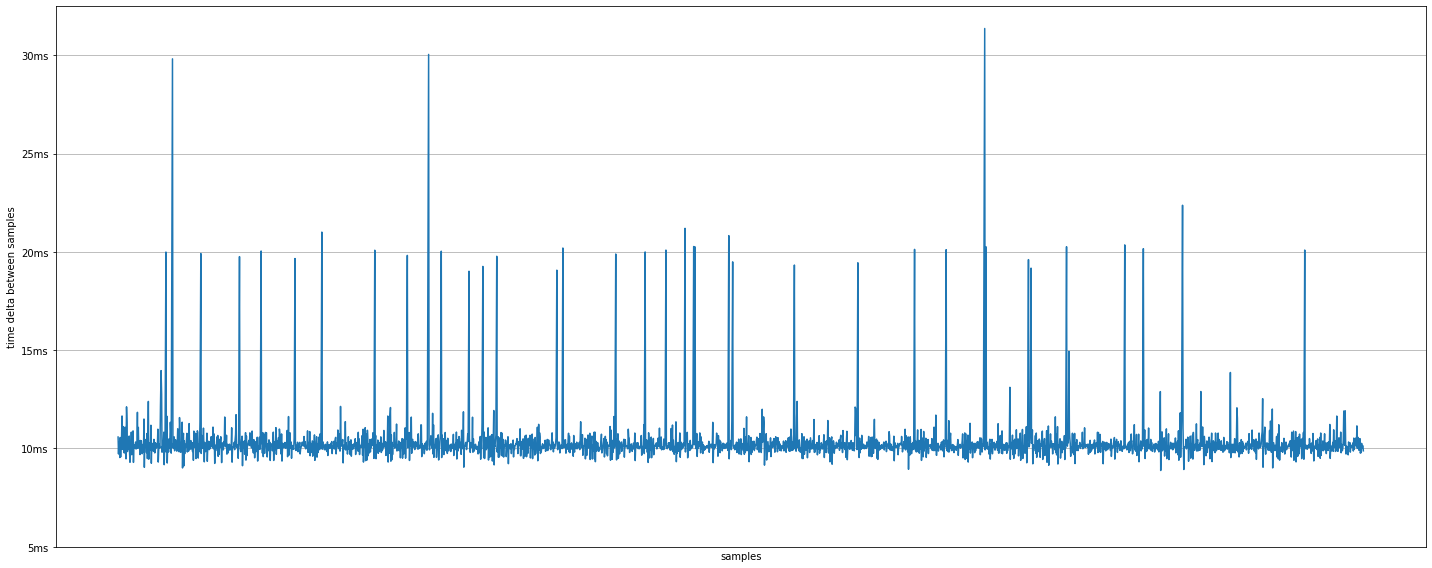

Highest value is  0 days 00:00:00.031361 row 1965 time 1970-01-01 11:47:23.795702
Lowest value is  0 days 00:00:00.008881 row 2365 time 1970-01-01 11:47:27.919218


In [ ]:
#plots the delta between time samples
#nominal for mobiact is 10mS since it is 100Hz sampling
#generates warning but timedelta not at all straightforward
#https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html

df_delta = df_time_indexed.copy()
#df_delta = df_resampled.copy() #used to confirm resampling worked - is line
df_delta['abs_time'] = df_delta.index
df_delta['delta'] = (df_delta['abs_time'] - df_delta['abs_time']
                     .shift(periods=1, fill_value=0))
#df_delta['delta'] = df_delta['delta']/1000000 #from nano to milliseconds
#this changed the look of the plot - need to adjust axis
df_delta = df_delta.iloc[3:] #1st few samples off, screws up plot range
#fig = plt.figure()
fig = df_delta['delta'].plot(figsize=(20,8))
#labels = labels/1000000
#plt.xticks(np.arange(1, df_delta.shape[0], 100).tolist())
plt.xticks([])
fig.set_xlabel('samples')
fig.set_ylabel('time delta between samples')
fig.set_yticks([5000000,10000000,15000000,20000000,25000000,30000000])
#plt.yticks(np.arange(50000000, 300000000, 500000000))
fig.set_yticklabels(['5ms', '10ms', '15ms', '20ms', '25ms','30ms'])
plt.tight_layout()
plt.grid(which='major')
plt.rcParams.update({'font.size': 25})
plt.savefig('/content/drive/MyDrive/Colab_Saved_Figures/sample_variation.pdf')
plt.show()
print('Highest value is ', df_delta['delta'].iloc[df_delta['delta'].argmax()],
      'row', df_delta['delta'].argmax(),'time', df_delta['delta'].idxmax())
print('Lowest value is ', df_delta['delta'].iloc[df_delta['delta'].argmin()],
      'row', df_delta['delta'].argmin(),'time', df_delta['delta'].idxmin())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  del sys.path[0]


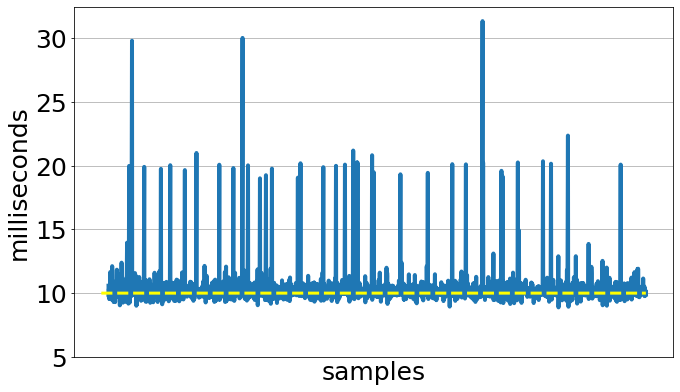

In [ ]:
#Modified plot for short format paper - two figures side-by-side

df_delta = df_time_indexed.copy()
df_delta['abs_time'] = df_delta.index
df_delta['delta'] = (df_delta['abs_time'] - df_delta['abs_time']
                     .shift(periods=1, fill_value=0))
df_delta = df_delta.iloc[3:] #1st few samples off, screws up plot range

df_resampled2 = to_fixed_timedelta(df_time_indexed, new_time_step='10ms')
df_delta2 = df_resampled2.copy() #used to confirm resampling worked - is line
df_delta2['abs_time'] = df_delta2.index
df_delta2['delta'] = (df_delta2['abs_time'] - df_delta2['abs_time']
                     .shift(periods=1, fill_value=0))
df_delta2 = df_delta2.iloc[3:] #1st few samples off, screws up plot range
fig = df_delta['delta'].plot(figsize=(10,6),linewidth=4)
plt.plot(df_delta2['delta'],linewidth=3,color='yellow',linestyle='dashed')
plt.xticks([])
fig.set_xlabel('samples')
#fig.set_xticks([1,2900])
#fig.set_xticklabels(['1', '2900'])
#fig.set_ylabel('\u0394 time (milliseconds)')
fig.set_ylabel('milliseconds')
fig.set_yticks([5000000,10000000,15000000,20000000,25000000,30000000])
fig.set_yticklabels(['5', '10', '15', '20', '25','30'])
plt.tight_layout()
plt.grid(which='major')
plt.rcParams.update({'font.size': 25})

#plt.text(0, 0, 'Min xxx\nMax yyy\n') #give figsize error, punt for now
plt.savefig('/content/drive/MyDrive/Colab_Saved_Figures/sample_var4.pdf')
plt.show()

In [ ]:
def get_processed_df_from_file(fname, new_time_step='50ms',
                               start_discard=10, end_discard=10):
    """processes mobiact file fname and returns dataframe of accel values
    inputs: fname = full filename of a mobiact datafile
            start_discard = number of initial samples to delete (default = 10)
            end_discard = number of final samples to delete (default = 10)
            Note: discard samples are after resampling
    output: pandas dataframe of shape (samples, accel_total)"""
    #TODO:  discard would be better in seconds not samples
    df = get_raw_mobiact_data(fname)
    df = add_total_accel(df)
    df = convert_index_to_datetime(df)
    df = to_fixed_timedelta(df,new_time_step)
    df = df.reset_index(drop=True) # index = row# not timedelta
    df.drop(df.head(start_discard).index,inplace=True) # drop first rows
    df.drop(df.tail(end_discard).index,inplace=True) # drop last rows
    return df

In [ ]:
def split_df_npX(df, time_steps = 500):
    """converts dataframe with time based data into 3D numpy array of shape
    (samples, time_steps, features). e.g. a 1800 row dataframe will
    result in a (3,500,1) numpy array.   The samples that don't populate an
    entire segment are discarded and there is no overlap (sliding window)
    input:  dataframe with one files worth of data indexed by time_step,
                 columns = features e.g. total_accel
            time_steps = # of datapoints (rows) in each sample default = 500
    ouput:  numpy array in trainX format 
            shape = (samples, time_steps, features)"""
    temp = df.to_numpy() # easier to reshape and final form needed anyway
    if (temp.shape[0]//time_steps)==0:
        print ("WARNING:  File contains less than ",time_steps,"time steps and is discarded")
    temp2 = temp[0:time_steps*(temp.shape[0]//time_steps)] # truncate to multiple of time_steps
    tempX = temp2.reshape(-1,time_steps,4) # won't work with out truncation
    return tempX

# "Main" function

In [ ]:
def mobiact_get_xys(
    df_flist, #pandas dataframe with list of filenames to process
    new_time_step = '50ms', #convert (resample) to this fixed time step (delta)
    time_steps = 500, #number of timesteps per sample
    start_discard=100, #drop rows at beginning of each test file
    end_discard=100 #drop rows at end of each test file
    ):
    """Main function, takes a list of mobiact filenames + metadata and builds
    three numpy arrays.  Returns X, y, sub and a text string of config info"""
    vprint("Processing mobiact data to X, y, sub numpy arrays")
    info = ("delta time step = " + new_time_step \
           + " time steps = " + str(time_steps) + ", start_discard = "\
           + str(start_discard) + ", end_discard = " + str(end_discard))
    vprint(info)
    my_X = np.zeros(shape=(1,time_steps,4))
    my_y = np.full(shape=(1,1), fill_value='n/a',dtype='U3') # unicode 3 char
    my_sub = np.zeros(shape=(1,1),dtype=int) # one subject number per entry
    for i in df_flist.index:
        #print ("processing file", df_flist['fname'][i])
        df = get_processed_df_from_file(df_flist['fname'][i], new_time_step,
                                        start_discard,end_discard)
        tempX = split_df_npX(df,time_steps)
        my_X = np.vstack([my_X, tempX])
        tempy = np.full(shape=(tempX.shape[0],1), 
                        fill_value=df_flist['ACT'][i],dtype='U3')
        my_y = np.vstack([my_y, tempy])
        tempsub = np.zeros(shape=(tempX.shape[0],1),dtype=int) #same rows, 1 sub
        tempsub[:]= df_flist['SUB'].astype(int)[i] #pandas entry is string
        my_sub = np.vstack([my_sub, tempsub])
    #delete first row placeholders
    X = np.delete(my_X, (0), axis=0) 
    y = np.delete(my_y, (0), axis=0) 
    sub = np.delete(my_sub, (0), axis=0)
    #check for nan - issue with resampled data
    bad_data_locations = np.argwhere(np.isnan(X))
    np.unique(bad_data_locations[:,0]) #[:,0] accesses just 1st column
    if (bad_data_locations.size==0):
        vprint("No NaN entries found")
    else:
        print("Warning: Output arrays contain NaN entries")
        print("execute print(X[99]) # to view single sample")
        info += "Warning: Output arrays contain NaN entries"
    return X, y, sub, info

# Generate all nparrays based on passed parameters and store on drive
This is the main automated function which will build the entire directory. 
Mobiact_Sample_Freq_Table.xlsx can be used to partially autogenerate this list if additional entries are needed.
The no_resample version used in the paper was manually generated by changing the entry and commenting out the entire resample sequence.

In [ ]:
base_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys_temp/'
#worklist contains [filename, resample value (step size), timestep/sample (3s),
#                  timesteps to cut off beginning, and end]
full_list = [[base_dir + 'mobiact_xys_5Hz_3s', '200ms', 15, 5, 5],
            [base_dir + 'mobiact_xys_10Hz_3s', '100ms', 30, 10, 10],
            [base_dir + 'mobiact_xys_15Hz_3s', '67ms', 45, 15, 15],
            [base_dir + 'mobiact_xys_20Hz_3s', '50ms', 60, 20, 20],
            [base_dir + 'mobiact_xys_25Hz_3s', '40ms', 75, 25, 25],
            [base_dir + 'mobiact_xys_30Hz_3s', '33ms', 90, 30, 30],
            [base_dir + 'mobiact_xys_40Hz_3s', '25ms', 120, 40, 40],
            [base_dir + 'mobiact_xys_60Hz_3s', '17ms', 180, 60, 60],
            [base_dir + 'mobiact_xys_80Hz_3s', '12ms', 240, 80, 80],
            [base_dir + 'mobiact_xys_100Hz_3s', '10ms', 300, 100, 100]]

In [ ]:
for x in full_list: 
    output_dir = x[0]
    X, y, sub, xys_info = mobiact_get_xys(df_flist,
        new_time_step = x[1],                                       
        time_steps = x[2],
        start_discard = x[3],
        end_discard = x[4])
    shapes = "X shape is " + str(X.shape) + " data type is " + str(X.dtype)\
            + "\ny shape is " + str(y.shape) + " data type is " + str(y.dtype)\
            + "\nsub shape is " + str(sub.shape) + " data type is " + str(sub.dtype)
    print ("Creating and storing in ",output_dir)
    !mkdir "$output_dir"
    summary = "MobiAct Data resampled with 3s window size\n"
    summary += "Saved to " + output_dir + "\n"
    from requests import get
    filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    summary += "Generated by " + filename
    import time
    summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())

    info_fname = output_dir+'/'+'info.txt'
    full_info = summary + "\n" + xys_info + "\n" + shapes
    print(full_info)

    with open(info_fname, "w") as file_object:
        file_object.write(full_info)

    if True:
        np.save(output_dir + '/'+'X.npy',X)
        np.save(output_dir + '/'+'y.npy',y)
        np.save(output_dir + '/'+'sub.npy',sub)

Creating and storing in  /content/drive/My Drive/Processed_Datasets/mobiact_xys_temp/mobiact_xys_5Hz_3s
MobiAct Data resampled with 3s window size
Saved to /content/drive/My Drive/Processed_Datasets/mobiact_xys_temp/mobiact_xys_5Hz_3s
Generated by MobiAct_ADL_get_X_y_sub.ipynb on Apr-16-2021_1912
delta time step = 200ms time steps = 15, start_discard = 5, end_discard = 5
X shape is (13792, 15, 4) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type is int64
Creating and storing in  /content/drive/My Drive/Processed_Datasets/mobiact_xys_temp/mobiact_xys_10Hz_3s
MobiAct Data resampled with 3s window size
Saved to /content/drive/My Drive/Processed_Datasets/mobiact_xys_temp/mobiact_xys_10Hz_3s
Generated by MobiAct_ADL_get_X_y_sub.ipynb on Apr-16-2021_1912
delta time step = 100ms time steps = 30, start_discard = 10, end_discard = 10
X shape is (13792, 30, 4) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type

# Get the nparrays - manual version (old)

In [ ]:
X, y, sub, xys_info = mobiact_get_xys(df_flist,
    new_time_step = '50ms',                                       
    time_steps = 60,
    start_discard = 20,
    end_discard = 20)
shapes = "X shape is " + str(X.shape) + " data type is " + str(X.dtype)\
         + "\ny shape is " + str(y.shape) + " data type is " + str(y.dtype)\
         + "\nsub shape is " + str(sub.shape) + " data type is " + str(sub.dtype)
print(shapes)

X shape is (13792, 60, 4) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type is int64


#More Exploratory Code to check results

In [ ]:
#show number of samples per subject
#if the beginning/end trim or window are too large samples will be 
#lost for the shorter activities
unique_elements, counts_elements = np.unique(sub, return_counts=True)
print(" subject #",int(unique_elements[np.argmin(counts_elements)]),
      "has ",np.amin(counts_elements)," samples (min)\n",
      "subject #",int(unique_elements[np.argmax(counts_elements)]),
      "has ",np.amax(counts_elements)," samples (max)\n")
print("Sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))

 subject # 27 has  272  samples (min)
 subject # 2 has  276  samples (max)

Sample count per subject:
[[  2   3   4   5   6   7   8   9  10  11  12  16  18  19  20  21  22  23
   24  25  26  27  28  29  32  33  34  35  36  37  38  39  40  41  42  43
   44  45  46  47  48  49  50  51  52  53  54  55  56  57]
 [276 276 276 276 276 276 276 276 274 276 276 276 276 276 276 276 276 276
  276 276 276 272 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 274 276]]


In [ ]:
#Find min and max values for consistent plot scales
min_g = np.nanmin(X[::1])
max_g = np.nanmax(X[::1])
print ('min g value is',min_g,'max g value is',max_g)

min g value is -19.52711 max g value is 20.861604009799457


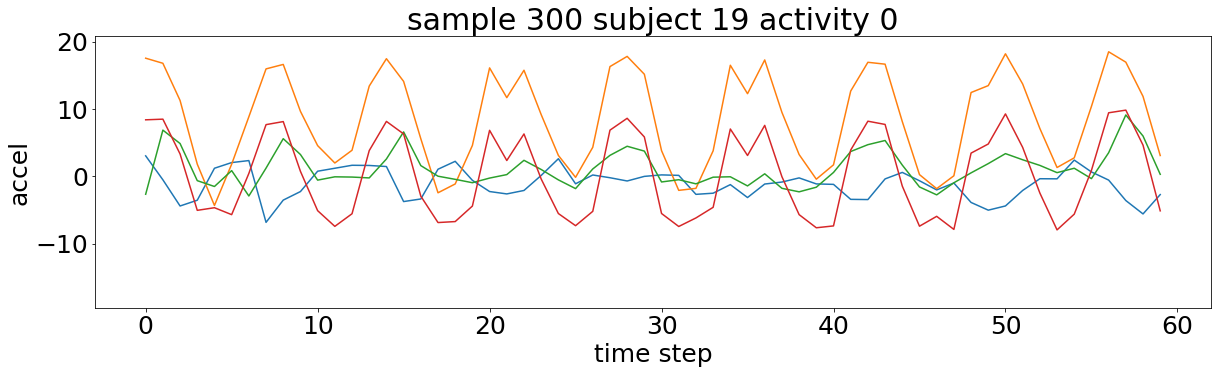

In [ ]:
#Plot a sample
sample_num = 300
plt.figure(figsize=(20,5))
plt.ylim([min_g, max_g])
plt.plot(X[sample_num])
plt.title('sample '+str(sample_num)+' subject '+str(int(sub[sample_num,0]))+' activity '+str(y[sample_num].argmax()))
plt.xlabel("time step")
plt.ylabel("accel")
plt.show()
